# Dependence:
- tensorflow-gpu 1.11
- keras 2.2.4

# Image augmentation and input data preparation

In [27]:
import os
import numpy as np
import glob
import cv2

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

datagen = ImageDataGenerator( rotation_range=90,
                              brightness_range=[0.1,0.8],
                             width_shift_range=0.2,
                             height_shift_range=0.2,
#                              shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode='constant',cval=255,                     
#                              rescale=1./255,
#                              channel_shift_range=0.2,
                             vertical_flip=True)

def imagepreprocessing(I):
    image = load_img(I).resize([224,224])
    image = img_to_array(image)  
    I = image
#     I = image/255
    return I

testdir = './my_crop/'
len([lists for lists in os.listdir(testdir) if os.path.isfile(os.path.join(testdir, lists))])

for parent,dirnames,filenames in os.walk(testdir): 
    for dirname in dirnames:     
        test_dir = parent+dirname
        print("test dir is:" +test_dir)
        imagenum = len([lists for lists in os.listdir(test_dir) if os.path.isfile(os.path.join(test_dir, lists))])

        i = 0
        testimage = np.zeros(shape=(imagenum,224,224,3))

        for img_name in glob.glob(test_dir+'/*.jpg'):
            testimage[i,:,:,:] =  imagepreprocessing(img_name)
            i +=1  
        print(testimage.shape)

        i = 0
        save_path = './my_crop_aug/'+dirname
        
        if os.path.isdir(save_path): 
            pass
        else:
            os.makedirs(save_path) 

        for batch in datagen.flow(testimage, 
                                  batch_size=32,
                                  save_to_dir=save_path,  
                                  save_format='jpg'):
            i +=1
            if i ==(np.ceil(imagenum/32)*10):
                break 

test dir is:./my_crop/Tomato___Bacterial_spot
(34, 224, 224, 3)
test dir is:./my_crop/Tomato___Tomato_Yellow_Leaf_Curl_Virus
(112, 224, 224, 3)
test dir is:./my_crop/Tomato___Leaf_Mold
(57, 224, 224, 3)
test dir is:./my_crop/Tomato___Spider_mites Two-spotted_spider_mite
(18, 224, 224, 3)
test dir is:./my_crop/Tomato___Tomato_mosaic_virus
(111, 224, 224, 3)
test dir is:./my_crop/Tomato___healthy
(82, 224, 224, 3)
test dir is:./my_crop/Tomato___Late_blight
(63, 224, 224, 3)
test dir is:./my_crop/Tomato___Septoria_leaf_spot
(51, 224, 224, 3)
test dir is:./my_crop/Tomato___Early_blight
(61, 224, 224, 3)
test dir is:./my_crop/Tomato___Target_Spot
(11, 224, 224, 3)


In [1]:
import os
import random
import shutil
import PIL.Image as Image

def mkdir(path):       
    import os
    path = path.strip()    
    path = path.rstrip("\\")      
    isExists = os.path.exists(path)

    if not isExists:        
        os.makedirs(path) 
        print(path)
        print('Make the directory')
        return True
    else:      
        print(path)
        print('The directory exist')
        return False
 

def eachFile(filepath):
    pathDir =  os.listdir(filepath)
    child_file_name=[]
    full_child_file_list = []
    for allDir in pathDir:
        child = os.path.join('%s%s' % (filepath, allDir))      
        full_child_file_list.append(child)
        child_file_name.append(allDir)
    return  full_child_file_list,child_file_name
 
def eachFile1(filepath):
    dir_list = []
    name_list = []
    pathDir =  os.listdir(filepath)
    for allDir in pathDir:
        name_list.append(allDir)
        child = os.path.join('%s%s' % (filepath+'/', allDir))
        dir_list.append(child)
    return  dir_list,name_list
 
def datapreparation(datasetname):
    filePath,danzi_list = eachFile("./"+datasetname+"/")
    for i in danzi_list:
        path  = './newtrain/' +i
        mkdir(path)
        path = './newtest/' + i
        mkdir(path)
        
    train_pic_dir=[]
    test_pic_dir=[]
    for i in filePath:
        pic_dir,pic_name=eachFile1(i)
        random.shuffle(pic_dir)
        train_list=pic_dir[0:int(0.9*len(pic_dir))]
        test_list=pic_dir[int(0.9*len(pic_dir)):]
        for j in train_list:   
            fromImage = Image.open(j)
            j=j.replace(datasetname,'newtrain')
            fromImage.save(j)
        for k in test_list:
            fromImage = Image.open(k)
            k=k.replace(datasetname,'newtest')
            fromImage.save(k)        


if __name__ == '__main__':
#     datapreparation('color')
    datapreparation('my_crop_aug')

./newtrain/Tomato___Bacterial_spot
The directory exist
./newtest/Tomato___Bacterial_spot
The directory exist
./newtrain/Tomato___Tomato_Yellow_Leaf_Curl_Virus
The directory exist
./newtest/Tomato___Tomato_Yellow_Leaf_Curl_Virus
The directory exist
./newtrain/Tomato___Leaf_Mold
The directory exist
./newtest/Tomato___Leaf_Mold
The directory exist
./newtrain/Tomato___Spider_mites Two-spotted_spider_mite
The directory exist
./newtest/Tomato___Spider_mites Two-spotted_spider_mite
The directory exist
./newtrain/Tomato___Tomato_mosaic_virus
The directory exist
./newtest/Tomato___Tomato_mosaic_virus
The directory exist
./newtrain/Tomato___healthy
The directory exist
./newtest/Tomato___healthy
The directory exist
./newtrain/Tomato___Late_blight
The directory exist
./newtest/Tomato___Late_blight
The directory exist
./newtrain/Tomato___Septoria_leaf_spot
The directory exist
./newtest/Tomato___Septoria_leaf_spot
The directory exist
./newtrain/Tomato___Early_blight
The directory exist
./newtest/Tom

# Training VGG16

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import numpy as np
import keras.layers as layers
from keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from keras.models import Sequential,Model
from keras.layers import Dropout, Flatten, Dense,Input
from keras import applications,metrics,optimizers
from keras import backend as K
from keras.callbacks import TensorBoard,EarlyStopping,ModelCheckpoint
from keras.utils import  plot_model

model = applications.VGG16(include_top=False, weights='imagenet')
imagesize =224

input = layers.Input(shape=(imagesize,imagesize,3),name='image_input')

x = layers.GlobalMaxPooling2D()(model(input))
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dense(128)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dense(64)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(10)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('softmax',name='pred')(x) 

model = Model(inputs = input, outputs= x)
model.summary()

train_data_dir = './newtrain/'

BATCH_SIZE =32
datagen = ImageDataGenerator(  rescale=1. / 255,
                             brightness_range=[0.1,0.8],
#                              channel_shift_range=0.5,
                             horizontal_flip=True,
                             vertical_flip=True,
                             validation_split=0.1,
                             rotation_range=90,
                             width_shift_range=0.3,
                             height_shift_range=0.3,                               
                             zoom_range=0.5
#                              shear_range=0.5
                            )
train_generator = datagen.flow_from_directory(directory=train_data_dir,
                                        target_size=(imagesize,imagesize), 
                                        batch_size=BATCH_SIZE,   
                                        class_mode='categorical',  
                                        shuffle=True,
                                        subset='training')
validation_generator = datagen.flow_from_directory(directory=train_data_dir,
                                        target_size=(imagesize,imagesize), 
                                        batch_size=BATCH_SIZE,   
                                        class_mode='categorical',  
                                        shuffle=True,
                                        subset='validation')
# print(train_generator.class_indices)

epochs = 50
sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
# adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.001/epochs)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['acc'])


callbacks = [
#     EarlyStopping(monitor='val_loss', patience=3),
    ModelCheckpoint(filepath="./model/VGG16_0401.h5", verbose=1, save_best_only=True),
    TensorBoard(log_dir="./log/VGG16_0401"),
]

history1 = model.fit_generator(generator=train_generator,
                    steps_per_epoch=len(train_generator),
                    validation_steps=len(validation_generator),
                    validation_data=validation_generator,
                    epochs=epochs,
                    shuffle=True,
                    callbacks=callbacks)
fw = open("history04011.txt",'w+')
fw.write(str(history1.history))    
fw.close()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 224, 224, 3)       0         
_________________________________________________________________
vgg16 (Model)                multiple                  14714688  
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
__________

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



# Training Inception_v3

In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import numpy as np
import keras.layers as layers
from keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from keras.models import Sequential,Model
from keras.layers import Dropout, Flatten, Dense,Input
from keras import applications,metrics,optimizers
from keras import backend as K
from keras.callbacks import TensorBoard,EarlyStopping,ModelCheckpoint
from keras.utils import  plot_model

model = applications.InceptionV3(include_top=False, weights='imagenet')

imagesize =224

input = layers.Input(shape=(imagesize,imagesize,3),name='image_input')

x = layers.GlobalMaxPooling2D()(model(input))
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dense(128)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dense(64)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(10)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('softmax',name='pred')(x) 

model = Model(inputs = input, outputs= x)
model.summary()

train_data_dir = './newtrain/'

BATCH_SIZE =24
datagen = ImageDataGenerator(  rescale=1. / 255,
                             brightness_range=[0.1,0.8],
#                              channel_shift_range=0.5,
                             horizontal_flip=True,
                             vertical_flip=True,
                             validation_split=0.1,
                             rotation_range=90,
                             width_shift_range=0.3,
                             height_shift_range=0.3,                               
                             zoom_range=0.5
#                              shear_range=0.5
                            )
train_generator = datagen.flow_from_directory(directory=train_data_dir,
                                        target_size=(imagesize,imagesize), 
                                        batch_size=BATCH_SIZE,   
                                        class_mode='categorical',  
                                        shuffle=True,
                                        subset='training')
validation_generator = datagen.flow_from_directory(directory=train_data_dir,
                                        target_size=(imagesize,imagesize), 
                                        batch_size=BATCH_SIZE,   
                                        class_mode='categorical',  
                                        shuffle=True,
                                        subset='validation')
# print(train_generator.class_indices)

epochs = 50
sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
# adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.001/epochs)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['acc'])


callbacks = [
#     EarlyStopping(monitor='val_loss', patience=3),
    ModelCheckpoint(filepath="./model/Inception_0401.h5", verbose=1, save_best_only=True),
    TensorBoard(log_dir="./log/Inception_0401"),
]

history2 = model.fit_generator(generator=train_generator,
                    steps_per_epoch=len(train_generator),
                    validation_steps=len(validation_generator),
                    validation_data=validation_generator,
                    epochs=epochs,
                    shuffle=True,
                    callbacks=callbacks)

fw = open("history04012.txt",'w+')
fw.write(str(history2.history))    
fw.close()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 224, 224, 3)       0         
_________________________________________________________________
inception_v3 (Model)         multiple                  21802784  
_________________________________________________________________
global_max_pooling2d_2 (Glob (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               524544    
_________________________________________________________________
batch_normalization_99 (Batc (None, 256)               1024      
_________________________________________________________________
activation_98 (Activation)   (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
__________


Epoch 00027: val_loss improved from 0.07060 to 0.07042, saving model to ./model/Inception_0401.h5
Epoch 28/50
815/815 [==============================] - 188s 231ms/step - loss: 0.1567 - acc: 0.9640 - val_loss: 0.1032 - val_acc: 0.9677

Epoch 00028: val_loss did not improve from 0.07042
Epoch 29/50
815/815 [==============================] - 188s 231ms/step - loss: 0.1588 - acc: 0.9639 - val_loss: 0.0788 - val_acc: 0.9742

Epoch 00029: val_loss did not improve from 0.07042
Epoch 30/50
815/815 [==============================] - 187s 230ms/step - loss: 0.1463 - acc: 0.9675 - val_loss: 0.1000 - val_acc: 0.9705

Epoch 00030: val_loss did not improve from 0.07042
Epoch 31/50
815/815 [==============================] - 201s 246ms/step - loss: 0.1380 - acc: 0.9689 - val_loss: 0.0622 - val_acc: 0.9820

Epoch 00031: val_loss improved from 0.07042 to 0.06220, saving model to ./model/Inception_0401.h5
Epoch 32/50
815/815 [==============================] - 200s 246ms/step - loss: 0.1335 - acc: 0.970

# Plot the training process

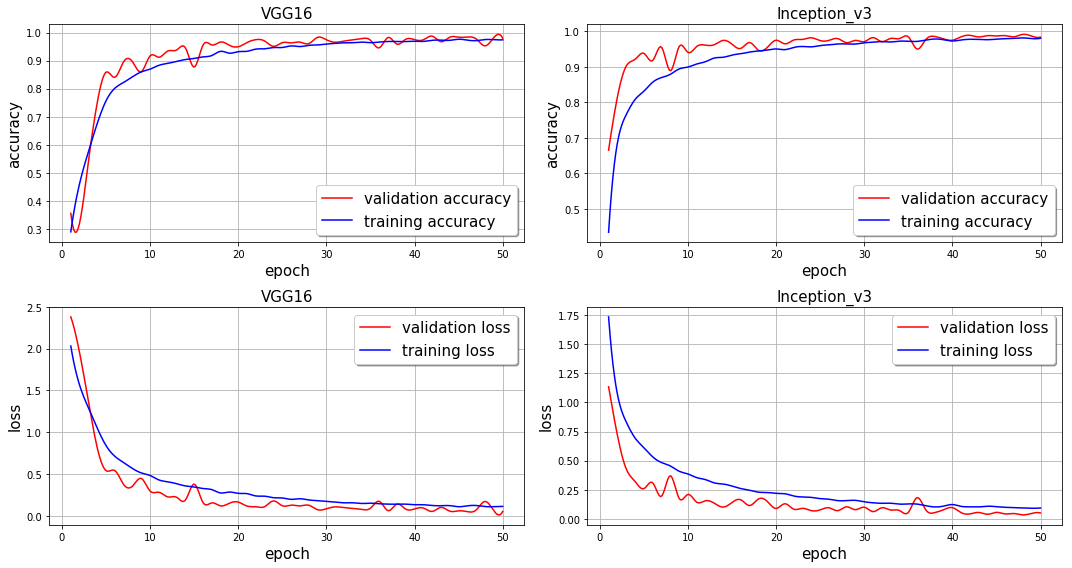

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate


def smoothline(val,T):  
    t, c, k = interpolate.splrep(T, val, s=0, k=3)
    smooth = interpolate.BSpline(t, c, k, extrapolate=True)
    return smooth



fr = open("history04011.txt",'r+')
history1 = eval(fr.read())   #读取的str转换为字典
fr.close()
fr = open("history04012.txt",'r+')
history2 = eval(fr.read())   #读取的str转换为字典
fr.close()

T = np.array(range(1,51))
val_acc_vgg = history1['val_acc']
acc_vgg = history1['acc']
val_loss_vgg = history1['val_loss']
loss_vgg = history1['loss']

val_acc_vgg_smooth = smoothline(val_acc_vgg,T)
acc_vgg_smooth = smoothline(acc_vgg,T)
val_loss_vgg_smooth = smoothline(val_loss_vgg,T)
loss_vgg_smooth = smoothline(loss_vgg,T)


val_acc_ince = history2['val_acc']
acc_ince = history2['acc']
val_loss_ince = history2['val_loss']
loss_ince = history2['loss']

val_acc_ince_smooth = smoothline(val_acc_ince,T)
acc_ince_smooth = smoothline(acc_ince,T)
val_loss_ince_smooth = smoothline(val_loss_ince,T)
loss_ince_smooth = smoothline(loss_ince,T)


fig= plt.figure(figsize=(15,8))

# Returns the Axes instance
xnew = np.linspace(T.min(),T.max(),300) #300 represents number of points to make between T.min and T.max 

ax1 = fig.add_subplot(221) 
ax1.plot(xnew,val_acc_vgg_smooth(xnew) ,'r',label="validation accuracy")
ax1.plot(xnew,acc_vgg_smooth(xnew),'b',label="training accuracy")
ax1.legend(loc='best',shadow=True,prop={'size':15})
ax1.set_title('VGG16',fontsize='15')
ax1.set_xlabel('epoch',fontsize='15')
ax1.set_ylabel('accuracy',fontsize='15')
ax1.grid(True)

ax2 = fig.add_subplot(222) 
ax2.plot(xnew,val_acc_ince_smooth(xnew),'r',label="validation accuracy")
ax2.plot(xnew,acc_ince_smooth(xnew),'b',label="training accuracy")
ax2.legend(loc='best',shadow=True,prop={'size':15})
ax2.set_title('Inception_v3',fontsize='15')
ax2.set_xlabel('epoch',fontsize='15')
ax2.set_ylabel('accuracy',fontsize='15')
ax2.grid(True)

ax3 = fig.add_subplot(223) 
ax3.plot(xnew,val_loss_vgg_smooth(xnew) ,'r',label="validation loss")
ax3.plot(xnew,loss_vgg_smooth(xnew) ,'b',label="training loss")
ax3.legend(loc='best',shadow=True,prop={'size':15})
ax3.set_title('VGG16',fontsize='15')
ax3.set_xlabel('epoch',fontsize='15')
ax3.set_ylabel('loss',fontsize='15')
ax3.grid(True)

ax4 = fig.add_subplot(224) 
ax4.plot(xnew,val_loss_ince_smooth(xnew),'r',label="validation loss")
ax4.plot(xnew,loss_ince_smooth(xnew),'b',label="training loss")
ax4.legend(loc='best',shadow=True,prop={'size':15})
ax4.set_title('Inception_v3',fontsize='15')
ax4.set_xlabel('epoch',fontsize='15')
ax4.set_ylabel('loss',fontsize='15')
ax4.grid(True)

fig.tight_layout()
foo_fig = plt.gcf() # 'get current figure'
foo_fig.savefig('0401_traing_process_newtrain.pdf', dpi=300)
plt.show()

# Test and  Confusion matrix

In [19]:
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
inception_model = load_model('./model/Inception_0401.h5')
vgg_model = load_model('./model/VGG16_0401.h5')

test_data_dir = './InternetTest_seg//'

imagesize = 224
BATCH_SIZE = 32

datagen = ImageDataGenerator(rescale=1./ 255)
test_generator = datagen.flow_from_directory(directory=test_data_dir,
                                             shuffle=False,
                                             target_size=(imagesize, imagesize), 
                                             batch_size=BATCH_SIZE    )


inception_result = inception_model.evaluate_generator(test_generator,steps=len(test_generator),verbose=1)
vgg_result = vgg_model.evaluate_generator(test_generator,steps=len(test_generator),verbose=1)

print('inception model,loss:%f,accuracy:%f'%(inception_result[0],inception_result[1]))
print('vgg model,loss:%f,accuracy:%f'%(vgg_result[0],vgg_result[1]))

Found 110 images belonging to 10 classes.
4/4 [==============================] - 9s 2s/step
inception model,loss:0.726289,accuracy:0.827273
vgg model,loss:0.862955,accuracy:0.800000


Found 2419 images belonging to 10 classes.
76/76 [==============================] - 5s 64ms/step


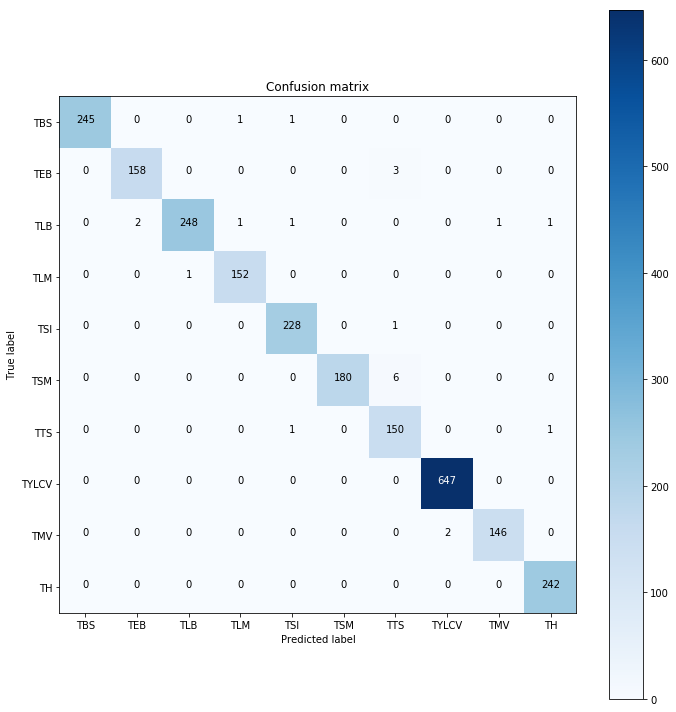

In [26]:
from matplotlib  import pyplot as plt
import itertools
from sklearn.metrics import  confusion_matrix
import numpy as np
test_data_dir='./newtest/'
test_generator = datagen.flow_from_directory(directory=test_data_dir,
                                             shuffle=False,
                                             target_size=(imagesize, imagesize), 
                                             batch_size=BATCH_SIZE    )
pred = inception_model.predict_generator(test_generator,verbose=1,steps=len(test_generator))
pred_lable = np.argmax(pred, axis=1)
cnf_matrix = confusion_matrix(test_generator.classes,pred_lable)

import scipy.io as sio 
sio.savemat('./saveddata.mat', {'groundth': test_generator.classes,'pred': pred_lable})

label = list(set(test_generator.classes))
classes = ['TBS',  'TEB',  'TLB', 'TLM',  'TSl', 'TSM',  'TTS',  'TYLCV','TMV', 'TH' ]
a = classes
# a = []
# for i in label:
#     a.append(classes[i])
    
plt.figure(figsize=(10,10))   
plt.imshow(cnf_matrix,  cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks =  np.arange(len(a))
plt.xticks(tick_marks, a, )
plt.yticks(tick_marks, a)

thresh = cnf_matrix.max() / 2.
for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    if cnf_matrix[i,j] ==0:
        text1 = cnf_matrix[i,j]
        fmt = 'd'
#         text1 = 'N'
#         fmt = 's'
         
    else:
        text1 = cnf_matrix[i,j]
        fmt = 'd'
    plt.text(j, i, format(text1, fmt),
             horizontalalignment="center",
             color="white" if cnf_matrix[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

In [27]:
test_generator.class_indices

{'Tomato___Bacterial_spot': 0,
 'Tomato___Early_blight': 1,
 'Tomato___Late_blight': 2,
 'Tomato___Leaf_Mold': 3,
 'Tomato___Septoria_leaf_spot': 4,
 'Tomato___Spider_mites Two-spotted_spider_mite': 5,
 'Tomato___Target_Spot': 6,
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 7,
 'Tomato___Tomato_mosaic_virus': 8,
 'Tomato___healthy': 9}

# Transfer '.h5' model to '.pb' model

In [10]:
import tensorflow as tf
import os

from tensorflow.python.framework import graph_util

from keras.models import load_model
from keras import backend as K


path_to_model = './model/Inception_0401.h5'
model = load_model(path_to_model)

K.set_learning_phase(0)

sess = K.get_session()
output_fld = './model/'
if not os.path.isdir(output_fld):
    os.mkdir(output_fld)
    
output_graph_name =  'Inception_0401.pb'
ouputname = model.output.name

constant_graph = graph_util.convert_variables_to_constants(sess, sess.graph.as_graph_def(), [ouputname[0:-2] ])
tf.train.write_graph(constant_graph, output_fld, output_graph_name, as_text=False)
print('saved the constant graph (ready for inference) at: ', os.path.join(output_fld, output_graph_name))


INFO:tensorflow:Froze 400 variables.
INFO:tensorflow:Converted 400 variables to const ops.
saved the constant graph (ready for inference) at:  ./model/Inception_0401.pb


# Check the scope name of  '.pb' model 

In [11]:
import tensorflow as tf

with tf.gfile.GFile('./model/Inception_0401.pb', "rb") as f:  
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    
with tf.Graph().as_default() as graph:  
    tf.import_graph_def(graph_def, name="")  
    for op in graph.get_operations(): 
        print(op.name, )

batch_normalization_1/keras_learning_phase/input
batch_normalization_1/keras_learning_phase
image_input_4
conv2d_1_2/kernel
conv2d_1_2/kernel/read
batch_normalization_5_2/beta
batch_normalization_5_2/beta/read
batch_normalization_5_2/moving_mean
batch_normalization_5_2/moving_mean/read
batch_normalization_5_2/moving_variance
batch_normalization_5_2/moving_variance/read
conv2d_2_2/kernel
conv2d_2_2/kernel/read
batch_normalization_6_2/beta
batch_normalization_6_2/beta/read
batch_normalization_6_2/moving_mean
batch_normalization_6_2/moving_mean/read
batch_normalization_6_2/moving_variance
batch_normalization_6_2/moving_variance/read
conv2d_3_2/kernel
conv2d_3_2/kernel/read
batch_normalization_7_2/beta
batch_normalization_7_2/beta/read
batch_normalization_7_2/moving_mean
batch_normalization_7_2/moving_mean/read
batch_normalization_7_2/moving_variance
batch_normalization_7_2/moving_variance/read
conv2d_4_2/kernel
conv2d_4_2/kernel/read
batch_normalization_8_2/beta
batch_normalization_8_2/be

# Activation Maximization 

In [6]:
%matplotlib inline
from vis.utils import utils
from vis.visualization import visualize_activation,visualize_cam
from vis.input_modifiers import Jitter
from keras import activations
from keras.models import load_model
from matplotlib import pyplot as plt
from keras import backend as K

K.clear_session()
model = load_model('./model/Inception_0401.h5',compile= False)
model.summary()
print('load done')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 224, 224, 3)       0         
_________________________________________________________________
inception_v3 (Model)         multiple                  21802784  
_________________________________________________________________
global_max_pooling2d_2 (Glob (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               524544    
_________________________________________________________________
batch_normalization_99 (Batc (None, 256)               1024      
_________________________________________________________________
activation_98 (Activation)   (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
__________

In [2]:
layer_idx = utils.find_layer_idx(model, 'pred')
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

/home/kai00004/.local/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [7]:
keptimage = []
for i in range(10):
    img = visualize_activation(model,layer_idx,filter_indices=i,
                               max_iter=50, verbose=1,
#                                seed_input=kept_filters[i][0],
#                                input_modifiers=[Jitter(16)]
                              )
    keptimage.append(img)

fig = plt.figure()
# plt.rcParams['figure.figsize'] = (50,50 )
title= [chr(i) for i in range(97,107)]
for i in range(10):
    plt.subplot(3,4,i+1,title=title[i])    
    plt.subplots_adjust(left=0, right=1,bottom=0,top=1)
    plt.imshow(keptimage[i])    
    plt.axis('off')
#     plt.tight_layout()
# fig.savefig("feature_map_inception0401.pdf",bbox_inches='tight', dpi=300)    

InvalidArgumentError: image_input:0 is both fed and fetched.

In [5]:
import sys
!{sys.executable} -m pip install -U keras-vis==0.5


  Could not find a version that satisfies the requirement keras-vis==0.5 (from versions: 0.1, 0.2, 0.2.1, 0.4, 0.4.1)
No matching distribution found for keras-vis==0.5


In [30]:
from __future__ import print_function

import time
import numpy as np
from PIL import Image as pil_image
from keras.preprocessing.image import save_img
from keras import layers
from keras.applications import vgg16
from keras import backend as K


def normalize(x):    
    return x / (K.sqrt(K.mean(K.square(x))) + K.epsilon())


def deprocess_image(x):   
    # normalize tensor: center on 0., ensure std is 0.25
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.25

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255    
    x = np.clip(x, 0, 255).astype('uint8')
    return x


def process_image(x, former):    
    return (x / 255 - 0.5) * 4 * former.std() + former.mean()

def visualize_layer(model,
                    layer_name,
                    step=1.,
                    epochs=15,
                    upscaling_steps=9,
                    upscaling_factor=1.2,
                    output_dim=(412, 412),
                    filter_range=(0, None)):   

    def _generate_filter_image(input_img,
                               layer_output,
                               filter_index):
       
        s_time = time.time()

        # we build a loss function that maximizes the activation
        # of the nth filter of the layer considered
       
        loss = K.mean(layer_output[:, filter_index])

        # we compute the gradient of the input picture wrt this loss
        grads = K.gradients(loss, input_img)[0]

        # normalization trick: we normalize the gradient
        grads = normalize(grads)

        # this function returns the loss and grads given the input picture
        iterate = K.function([input_img], [loss, grads])

        # we start from a gray image with some random noise
        intermediate_dim = tuple(
            int(x / (upscaling_factor ** upscaling_steps)) for x in output_dim)
      
        input_img_data = np.random.random((1, intermediate_dim[0], intermediate_dim[1], 3))
        input_img_data = (input_img_data - 0.5) * 20 + 128

        # Slowly upscaling towards the original size prevents
        # a dominating high-frequency of the to visualized structure
        # as it would occur if we directly compute the 412d-image.
        # Behaves as a better starting point for each following dimension
        # and therefore avoids poor local minima
        for up in reversed(range(upscaling_steps)):
            # we run gradient ascent for e.g. 20 steps
            for _ in range(epochs):
                loss_value, grads_value = iterate([input_img_data])
                input_img_data += grads_value * step

                # some filters get stuck to 0, we can skip them
                if loss_value <= K.epsilon():
                    return None

            # Calulate upscaled dimension
            intermediate_dim = tuple(
                int(x / (upscaling_factor ** up)) for x in output_dim)
            # Upscale
            img = deprocess_image(input_img_data[0])
            img = np.array(pil_image.fromarray(img).resize(intermediate_dim,
                                                           pil_image.BICUBIC))
            input_img_data = [process_image(img, input_img_data[0])]

        # decode the resulting input image
        img = deprocess_image(input_img_data[0])
        e_time = time.time()
        print('Costs of filter {:3}: {:5.0f} ( {:4.2f}s )'.format(filter_index,
                                                                  loss_value,
                                                                  e_time - s_time))
        return img, loss_value

    def _draw_filters(filters, n=None):        
        if n is None:
            n = int(np.floor(np.sqrt(len(filters))))

        # the filters that have the highest loss are assumed to be better-looking.
        # we will only keep the top n*n filters.
        filters.sort(key=lambda x: x[1], reverse=True)
        filters = filters[:n * n]

        # build a black picture with enough space for
        # e.g. our 8 x 8 filters of size 412 x 412, with a 5px margin in between
        MARGIN = 5
        width = n * output_dim[0] + (n - 1) * MARGIN
        height = n * output_dim[1] + (n - 1) * MARGIN
        stitched_filters = np.zeros((width, height, 3), dtype='uint8')

        # fill the picture with our saved filters
        for i in range(n):
            for j in range(n):
                img, _ = filters[i * n + j]
                width_margin = (output_dim[0] + MARGIN) * i
                height_margin = (output_dim[1] + MARGIN) * j
                stitched_filters[
                    width_margin: width_margin + output_dim[0],
                    height_margin: height_margin + output_dim[1], :] = img

        # save the result to disk
        save_img('vgg_{0:}_{1:}x{1:}.png'.format(layer_name, n), stitched_filters)

    # this is the placeholder for the input images
    assert len(model.inputs) == 1
    input_img = model.inputs[0]

    # get the symbolic outputs of each "key" layer (we gave them unique names).
    layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])

    output_layer = layer_dict[layer_name]
    assert isinstance(output_layer, layers.Activation)

    # Compute to be processed filter range
    filter_lower = filter_range[0]
    filter_upper = (filter_range[1]
                    if filter_range[1] is not None
                    else output_layer.output_shape[1])
    assert (filter_lower > output_layer.output_shape[1])
    print('Compute filters {:} to {:}'.format(filter_lower, filter_upper))

    # iterate through each filter and generate its corresponding image
    processed_filters = []
    for f in range(filter_lower, filter_upper):
        img_loss = _generate_filter_image(input_img, output_layer.output, f)

        if img_loss is not None:
            processed_filters.append(img_loss)

    print('{} filter processed.'.format(len(processed_filters)))
    # Finally draw and store the best filters to disk
    _draw_filters(processed_filters)


if __name__ == '__main__':
    # the name of the layer we want to visualize
    # (see model definition at keras/applications/vgg16.py)
    LAYER_NAME = 'pred'

    # build the VGG16 network with ImageNet weights
    model = load_model('./model/Inception_0401.h5',compile= False)
#     vgg = vgg16.VGG16(weights='imagenet', include_top=False)
    print('Model loaded.')
    model.summary()

    # example function call
    visualize_layer(model, LAYER_NAME)

Model loaded.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 224, 224, 3)       0         
_________________________________________________________________
inception_v3 (Model)         multiple                  21802784  
_________________________________________________________________
global_max_pooling2d_2 (Glob (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               524544    
_________________________________________________________________
batch_normalization_99 (Batc (None, 256)               1024      
_________________________________________________________________
activation_98 (Activation)   (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896  

KeyboardInterrupt: 

In [35]:
output_layer.output
model.output[:, 1]

<tf.Tensor 'strided_slice_24:0' shape=(?,) dtype=float32>